This notebook is an implementation of REACT AGENT using langGraph.



## Installing and Importing the Libraries

In [12]:
#pip install pandas numpy faiss-cpu sentence-transformers openai scikit-learn seaborn python-dotenv langchain_community chromadb sqlite3

In [40]:
import pandas as pd
import numpy as np
import json
import re
from typing import List, Dict, Any, Tuple
import faiss
from sentence_transformers import SentenceTransformer
from openai import OpenAI
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from dotenv import load_dotenv
import openai
import os
import chromadb
import sqlite3
from langchain_community.utilities import GoogleSerperAPIWrapper
from math import radians, cos, sin, sqrt, atan2



# ✅ Load environment variables
load_dotenv()
openai_api_key = os.getenv("OPEN_AI_KEY")
SERPER_API_KEY = os.getenv("SERPER_API_KEY")
GEOCODE_API_KEY = os.getenv("GEOCODE_API_KEY")



## Downloading the Medical Q&A Dataset

In [17]:
## Data 1: reading the Comprehensive Medical Q&A Dataset
df_qa = pd.read_csv("medical_q_n_a.csv")
## Data has 16407 rows, hence we will sample 500 rows for experimentation
df_qa = df_qa.sample(500, random_state=0).reset_index(drop=True)
print(df_qa.shape)
df_qa.head()

(500, 3)


,qtype,Question,Answer
0,frequency,How many people are affected by X-linked chond...,The prevalence of X-linked chondrodysplasia pu...
1,treatment,What are the treatments for Kawasaki disease ?,These resources address the diagnosis or manag...
2,genetic changes,What are the genetic changes related to Ellis-...,Ellis-van Creveld syndrome can be caused by mu...
3,symptoms,What are the symptoms of Renal dysplasia-limb ...,What are the signs and symptoms of Renal dyspl...
4,information,What is (are) Fraser syndrome ?,Fraser syndrome is a rare disorder that affect...


In [18]:
# Preparing the Dataframe for Vector DB by combining the Text
df_qa['combined_text'] = (
    "Question: " + df_qa['Question'].astype(str) + ". " +
    "Answer: " + df_qa['Answer'].astype(str) + ". " +
    "Type: " + df_qa['qtype'].astype(str) + ". "
)

df_qa.head()

,qtype,Question,Answer,combined_text
0,frequency,How many people are affected by X-linked chond...,The prevalence of X-linked chondrodysplasia pu...,Question: How many people are affected by X-li...
1,treatment,What are the treatments for Kawasaki disease ?,These resources address the diagnosis or manag...,Question: What are the treatments for Kawasaki...
2,genetic changes,What are the genetic changes related to Ellis-...,Ellis-van Creveld syndrome can be caused by mu...,Question: What are the genetic changes related...
3,symptoms,What are the symptoms of Renal dysplasia-limb ...,What are the signs and symptoms of Renal dyspl...,Question: What are the symptoms of Renal dyspl...
4,information,What is (are) Fraser syndrome ?,Fraser syndrome is a rare disorder that affect...,Question: What is (are) Fraser syndrome ?. Ans...


## Downloading the USA Hospital Dataset

In [36]:
## Data 2: reading the USA Hospitals Dataset
## This dataset contains information about hospitals in the USA including their location, type, number of beds, and other relevant details.
df_hospital = pd.read_csv("Hospitals.csv")
print(df_hospital.shape)
df_hospital[["LATITUDE", "LONGITUDE", "CITY", "STATE", "TYPE", "NAME", "ADDRESS", "BEDS", "WEBSITE", "COUNTRY"]].head()

(7570, 34)


,LATITUDE,LONGITUDE,CITY,STATE,TYPE,NAME,ADDRESS,BEDS,WEBSITE,COUNTRY
0,29.747620,-94.945477,BAYTOWN,TX,GENERAL ACUTE CARE,HOUSTON METHODIST SAN JACINTO HOSPITAL ALEXAND...,1700 JAMES BOWIE DRIVE,182.0,http://www.houstonmethodist.org/locations/san-...,USA
1,40.027143,-82.881843,COLUMBUS,OH,SPECIAL,"WOODS AT PARKSIDE,THE",349 OLDE RIDENOUR ROAD,50.0,http://www.thewoodsatparkside.com/,USA
2,39.774242,-84.168027,DAYTON,OH,CHILDREN,DAYTON CHILDREN'S HOSPITAL,ONE CHILDRENS PLAZA,155.0,http://www.childrensdayton.org/cms/home/index....,USA
3,41.005169,-80.632972,BOARDMAN,OH,LONG TERM CARE,VIBRA HOSPITAL OF MAHONING VALLEY,8049 SOUTH AVENUE,45.0,http://www.mahoningvalleyhospital.com/,USA
4,39.747740,-84.199398,DAYTON,OH,PSYCHIATRIC,HAVEN BEHAVIORAL SENIOR CARE OF DAYTON,"ONE ELIZABETH PLACE,E3 SUITE A",32.0,https://dayton.havenbehavioral.com/,USA


In [37]:
df_hospital[["LATITUDE", "LONGITUDE", "CITY", "STATE", "TYPE", "NAME", "ADDRESS", "BEDS", "WEBSITE", "COUNTRY"]].head().to_clipboard()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Setting up the Vector Store

In [14]:
import chromadb
# Setting up the Chromadb
client = chromadb.PersistentClient(path="./chroma_db")

In [15]:
# Collection 1 for medical Q&A Dataset
collection1 = client.get_or_create_collection(name="medical_q_n_a")

In [19]:
# Add data to collection
# here the chroma db will use default embeddings (sentence transformers)
collection1.add(
    documents=df_qa['combined_text'].tolist(),
    metadatas=df_qa.to_dict(orient="records"),
    ids=df_qa.index.astype(str).tolist(),
)




In [20]:
# quick check
query = "What are the treatments for Kawasaki disease ?"

results = collection1.query(query_texts=[query],
    n_results=3
)
print(results)

{'ids': [['1', '393', '60']], 'embeddings': None, 'documents': [["Question: What are the treatments for Kawasaki disease ?. Answer: These resources address the diagnosis or management of Kawasaki disease:  - Cincinnati Children's Hospital Medical Center  - Genetic Testing Registry: Acute febrile mucocutaneous lymph node syndrome  - National Heart, Lung, and Blood Institute: How is Kawasaki Disease Treated?   These resources from MedlinePlus offer information about the diagnosis and management of various health conditions:  - Diagnostic Tests  - Drug Therapy  - Surgery and Rehabilitation  - Genetic Counseling   - Palliative Care. Type: treatment. ", 'Question: What are the treatments for Krabbe Disease ?. Answer: There is no cure for Krabbe disease. Results of a very small clinical trial of children with infantile Krabbe disease found that children who received umbilical cord blood stem cells from unrelated donors prior to symptom onset developed with little neurological impairment. Bon

## Setting WebSearch API

In [11]:
search = GoogleSerperAPIWrapper()

# testing the google search API
search.run(query="What are the various vaccines of COVID-19")

'Different types of COVID-19 vaccines: How they work · mRNA vaccine · mRNA vaccine · Messenger RNA (mRNA) vaccine · Viral vector vaccine · Viral vector vaccine ... First introduced in December 2020, the original COVID mRNA vaccines from both Pfizer and Moderna protected against the original SARS-CoV-2 virus ... Currently, there are two types of COVID-19 vaccines for use in the United States: mRNA, and protein subunit vaccines. None of these vaccines can ... COVID-19 vaccines include viral vector, genetic, inactivated, attenuated, and protein vaccines. These use different methods to stimulate an immune response. Types of COVID-19 vaccines. Two types of COVID-19 vaccines are recommended for use in the United States: mRNA vaccines. Moderna COVID-19 Vaccine ... Pfizer, Moderna, Novavax. Helps protect people of all ages against COVID-19 illness that is severe, requires hospital care, or causes death. List of COVID-19 vaccine authorizations · Contents · Overview maps · Oxford–AstraZeneca · P

## Setting Geocode API

In [ ]:
import requests
# this function gets the latitude and longitude of a given address using the Geocode API

def get_coordinates(address):
    url = "https://geocode.maps.co/search"
    params = {"q": address, "api_key": "GEOCODE_API_KEY"}  # API key optional for free tier
    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        if data:
            lat = data[0]["lat"]
            lon = data[0]["lon"]
            print(f"Latitude: {lat}, Longitude: {lon}")
            return lat, lon
        else:
            print("No results found.")
    else:
        print(f"Error: {response.status_code}")

# Example usage
get_coordinates("new york city")

Latitude: 40.7127281, Longitude: -74.0060152


('40.7127281', '-74.0060152')

## Setting up the Open AI API

In [144]:
from openai import OpenAI

def get_llm_response(prompt: str) -> str:
    """Function to get response from LLM"""
    from openai import OpenAI
    client_llm = OpenAI(api_key=openai_api_key)
    response = client_llm.chat.completions.create(
        model="gpt-5-mini",
        messages=[{"role": "user", "content": prompt}]
    )
    return response.choices[0].message.content

## testing the LLM response
prompt = "Explain the theory of relativity in simple terms in 30 words"
response = get_llm_response(prompt)

print(response)

Relativity: space and time are linked; measurements of distance, time, and simultaneity depend on motion. Gravity is curved spacetime caused by mass-energy, guiding objects and light along geodesics, affecting clocks.


## Defining the Tools

## Building the Graph

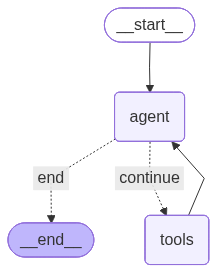

In [191]:
import json
from math import radians, cos, sin, sqrt, atan2
from langgraph.graph import StateGraph, END
from typing import TypedDict

# === State Schema ===
class AgentState(TypedDict):
    query: str
    last_agent_response: str
    tool_obervations: list
    num_steps: int
    user_location: str  # Optional field for follow-up location info

# === Stateless Tool Functions ===

def retrieve_context_q_n_a(query: str):
    """Stateless: returns relevant medical Q&A context."""
    print("---TOOLCALL: RETRIEVING CONTEXT---")
    results = collection1.query(query_texts=[query], n_results=3)
    context = "\n".join(results["documents"][0])
    return {"context": context, "source": "Medical Q&A Collection"}

def web_search(query: str):
    """Stateless: returns web search results."""
    print("---TOOLCALL: PERFORMING WEB SEARCH---")
    search_results = search.run(query=query)
    print(search_results)
    return {"context": search_results, "source": "Web Search"}

def search_nearest_hospital(user_location: str, specialty: str = None, top_n: int = 3):
    """Stateless: returns nearest hospitals based on location/specialty."""
    print("---SEARCHING NEAREST HOSPITAL---")
    user_coords = get_coordinates(user_location)
    if not user_coords:
        return {"error": "Could not get coordinates"}
    user_lat, user_lon = user_coords

    def haversine(lat1, lon1, lat2, lon2):
        lat1, lon1, lat2, lon2 = map(radians, [float(lat1), float(lon1), float(lat2), float(lon2)])
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
        c = 2 * atan2(sqrt(a), sqrt(1-a))
        return 6371 * c  # km

    if specialty:
        filtered_df = df_hospital[df_hospital['TYPE'].str.contains(specialty, case=False, na=False)]
    else:
        filtered_df = df_hospital.copy()

    filtered_df['distance_km'] = filtered_df.apply(
        lambda row: haversine(user_lat, user_lon, row['LATITUDE'], row['LONGITUDE']), axis=1
    )

    nearest = filtered_df.sort_values('distance_km').head(top_n)
    nearest["distance_km"] = nearest["distance_km"].round(2)
    results = nearest[['NAME','ADDRESS','CITY','STATE','TYPE','BEDS','WEBSITE','distance_km']].to_dict(orient='records')
    return {"context": results, "source": "Hospital Search"}

def ask_user(question: str):
    """Ask the user for input and return the response."""
    print(f"---USER INPUT REQUIRED---\n{question}")
    answer = input(f"{question}: ")  # This will pause the notebook and wait for input
    return {"context": answer, "source": "User Input"}

# === LLM Call ===
def call_model(state: dict) -> dict:
    print("\n")
    print("=== STEP", state.get("num_steps", 0), "===")
    print("---CALLING LLM MODEL---")
    query = state.get("query", "")
    tool_obervations = "\n".join(state.get("tool_obervations", []))
    user_location = state.get("user_location", "")

    tools_list = """
                    Available tools:

                    1. retrieve_context_q_n_a
                    Description: Retrieve relevant medical Q&A documents.
                    Arguments: query (string)

                    2. search_nearest_hospital
                    Description: Find nearest hospitals.
                    Arguments: user_location (string), specialty (string, optional), top_n (int, optional)

                    3. web_search
                    Description: Perform a web search.
                    Arguments: query (string)

                    4. ask_user
                    Description: Ask the user for missing info.
                    Arguments: question (string)
                """

    prompt = f"""
                You are a medical assistant with access to these actions:

                {tools_list}

                User query: "{query}"
        

                Past tool_obervations:
                {tool_obervations}

                Instructions:
                1. Always Start with THOUGHT, then decide on (ACTION and ARGUMENTS) or ANSWER.
                2. Carefully check past tool_obervations to see if the answer is already available.
                3. If not, choose the most relevant tool to gather more information.
                4. If any required info is missing (e.g., user location), use 'ask_user'.
                5. Please don't answer anything based on General knowledge or assumptions without sufficient information.
                6. ARGUMENTS must be valid JSON with keys in double quotes.
                7. Please don't add anything outside the specified format.


                ---

                Sample Session Example:

                User query: "What are the symptoms of Coronavirus?"

                THOUGHT: The user wants a cardiologist and has provided their location. I should find nearby hospitals with cardiology departments.
                ACTION: retrieve_context_q_n_a
                ARGUMENTS: {{"query": "symptoms of Coronavirus"}}
                
                [Tool results come back]

                THOUGHT: The retrieved context does not provides the symptoms of Coronavirus. I should now check the websearch.
                ACTION: websearch
                ARGUMENTS: {{"query": "symptoms of Coronavirus"}}
                [Tool results come back]

                THOUGHT: The retrieved context now provides the symptoms of Coronavirus. I should now check the websearch.
                ANSWER: "The symptoms of Coronavirus include fever, cough, fatigue, loss of taste or smell, and difficulty breathing.(LIMIT TO 30 WORDS)"

                ---

        
                """

    response = get_llm_response(prompt)
    state["last_agent_response"] = response
    state["num_steps"] += 1
    print(response)
    return state

# === Tool Caller ===
def call_tool(state: dict) -> dict:
    action_text = state.get("last_agent_response", "")
    
    if "ACTION:" not in action_text:
        state.setdefault("tool_obervations", []).append(f"[No action found: {action_text}]")
        return state

    print(f"---CALLING TOOL---")
    tool_name = action_text.split("ACTION:")[1].split("\n")[0].strip()
    print(f"Tool to call: {tool_name}")

    args = {}
    if "ARGUMENTS:" in action_text:
        args_text = action_text.split("ARGUMENTS:")[1].strip()

        # Safely extract JSON block
        if args_text.startswith("{"):
            brace_count = 0
            end_index = 0
            for i, char in enumerate(args_text):
                if char == "{":
                    brace_count += 1
                elif char == "}":
                    brace_count -= 1
                if brace_count == 0:
                    end_index = i + 1
                    break
            args_text = args_text[:end_index]

        try:
            args = json.loads(args_text)
            print(f"Parsed arguments: {args}")
        except json.JSONDecodeError:
            print(f"Failed to parse JSON arguments: {args_text}")
            state.setdefault("tool_obervations", []).append(f"[Failed to parse arguments: {args_text}]")
            args = {}

    # Map to stateless tools
    tool_map = {
        "retrieve_context_q_n_a": retrieve_context_q_n_a,
        "search_nearest_hospital": search_nearest_hospital,
        "web_search": web_search,
        "ask_user": ask_user
    }

    if tool_name in tool_map:
        results = tool_map[tool_name](**args)

        if tool_name == "ask_user":
            # Append user input to observations
            state.setdefault("tool_obervations", []).append(f"[User input: {results['context']}]")
            # Save user_location if question mentions it
            if "location" in args.get("question", "").lower():
                state["user_location"] = results["context"]
        else:
            # Append tool results
            state.setdefault("tool_obervations", []).append(f"[{tool_name} results: {results['context']}]")
            state["last_tool_results"] = results
            print(results)
        return state

    state.setdefault("tool_obervations", []).append(f"[Unknown tool: {tool_name}]")
    return state



# === Should Continue ===
def should_continue(state: dict) -> str:
    last_agent_response = state.get("last_agent_response", "")
    if "ANSWER:" in last_agent_response.upper():
        print("Found answer in the last action text, ending workflow.")
        return "end"
    print("--Continuing workflow.")
    return "continue"

# === Workflow Graph ===
workflow = StateGraph(state_schema=AgentState)
workflow.add_node("agent", call_model)
workflow.add_node("tools", call_tool)
workflow.set_entry_point("agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {"continue": "tools", "end": END}
)

workflow.add_edge("tools", "agent")
agentic_graph = workflow.compile()

# === Visualize ===
from IPython.display import Image, display
display(Image(agentic_graph.get_graph().draw_mermaid_png()))


### Query 1: Medical Symptoms Related Query

In [190]:
agent_state = {
    "query": "What are the symptoms of HIV virus?",
    "last_agent_response": "",
    "tool_obervations": [],
    "num_steps": 0
}
result = agentic_graph.invoke(agent_state)



=== STEP 0 ===
---CALLING LLM MODEL---
THOUGHT: I should first check existing medical Q&A documents for accurate information about HIV symptoms.
ACTION: retrieve_context_q_n_a
ARGUMENTS: {"query": "symptoms of HIV"}
--Continuing workflow.
---CALLING TOOL---
Tool to call: retrieve_context_q_n_a
Parsed arguments: {'query': 'symptoms of HIV'}
---TOOLCALL: RETRIEVING CONTEXT---
{'context': "Question: What are the symptoms of Hyper-IgD syndrome ?. Answer: What are the signs and symptoms of Hyper-IgD syndrome? Hyper IgD syndrome is characterized by periodic high fevers accompanied by lymphadenopathy, abdominal pain, diarrhea, headache, joint pain, hepatomegaly and/or splenomegaly, and skin lesions. Most episodes last several days and occur periodically throughout life. The frequency of episodes and their severity vary greatly from case to case. The first attack usually takes place during infancy. Patients may have no symptoms between attacks. However, in some patients, the attacks may be s

### Query 2: Hospital Related Query

In [192]:
agent_state = {
    "query": "I am looking for a nearest hospital?",
    "last_agent_response": "",
    "tool_obervations": [],
    "num_steps": 0,
    "user_location": ""
}
result = agentic_graph.invoke(agent_state)



=== STEP 0 ===
---CALLING LLM MODEL---
THOUGHT: The user did not provide their location or any specialty/emergency need, so I need to ask for that before searching for nearby hospitals.
ACTION: ask_user
ARGUMENTS: {"question":"Please provide your current location (address, city, or ZIP/postal code). Do you need a specific specialty (e.g., cardiology) or emergency care?"}
--Continuing workflow.
---CALLING TOOL---
Tool to call: ask_user
Parsed arguments: {'question': 'Please provide your current location (address, city, or ZIP/postal code). Do you need a specific specialty (e.g., cardiology) or emergency care?'}
---USER INPUT REQUIRED---
Please provide your current location (address, city, or ZIP/postal code). Do you need a specific specialty (e.g., cardiology) or emergency care?


=== STEP 1 ===
---CALLING LLM MODEL---
THOUGHT: The user provided their location ("Newyork"); I should find the nearest hospitals to that location.
ACTION: search_nearest_hospital
ARGUMENTS: {"user_location"